In [1]:
import os, pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
print("TensorFlow:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


TensorFlow: 2.20.0
GPU available: []


In [2]:
import pathlib

DATA_DIR = pathlib.Path("../data")  # go up one level since notebook is inside notebooks/
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
SEED = 42

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR / "train", image_size=IMG_SIZE, batch_size=BATCH_SIZE, seed=SEED
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR / "val", image_size=IMG_SIZE, batch_size=BATCH_SIZE, seed=SEED
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR / "test", image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False
)

class_names = train_ds.class_names
class_names


Found 1600 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


['COVID', 'NORMAL']

In [3]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)

normalization = layers.Rescaling(1./255)


In [4]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(factor=0.1)
])


In [5]:
inputs = keras.Input(shape=(*IMG_SIZE, 3))
x = normalization(inputs)
x = data_augmentation(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation="relu")(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(128, 3, activation="relu")(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,506 (365.26 KB)

 Trainable params: 93,506 (365.26 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
]
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacks
)


Epoch 1/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 187ms/step - accuracy: 0.4944 - loss: 0.7646 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 2/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 212ms/step - accuracy: 0.4906 - loss: 0.6950 - val_accuracy: 0.5025 - val_loss: 0.6933
Epoch 3/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 208ms/step - accuracy: 0.4975 - loss: 0.6942 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 4/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 202ms/step - accuracy: 0.4988 - loss: 0.6967 - val_accuracy: 0.4575 - val_loss: 0.6935
Epoch 5/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 207ms/step - accuracy: 0.4756 - loss: 0.6959 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 213ms/step - accuracy: 0.5094 - loss: 0.6973 - val_accuracy: 0.5000 - val_loss: 0.6926
Epoch 7/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 203ms/step - accuracy: 0.5088 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 8/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 205ms/step - accuracy: 0.4856 - loss: 0.6936 - val_accu

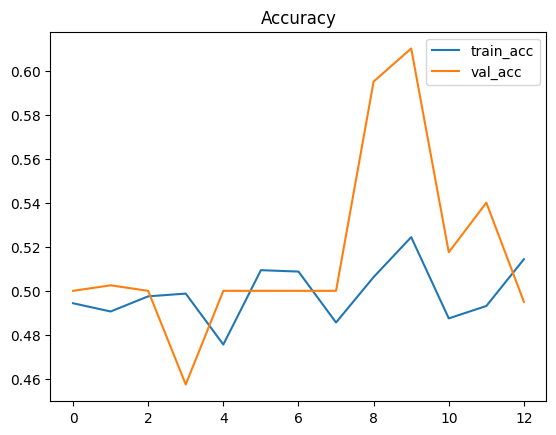

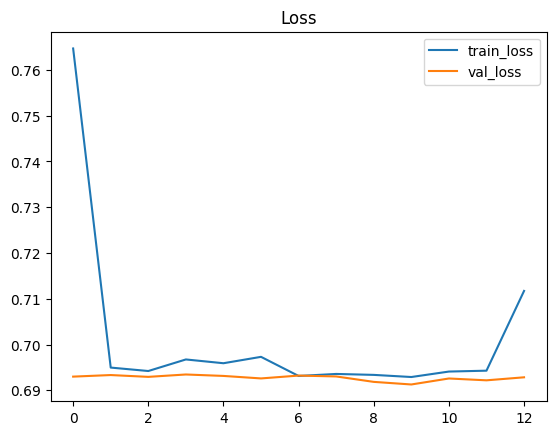

In [7]:
plt.figure()
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.legend(); plt.title("Accuracy"); plt.show()

plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend(); plt.title("Loss"); plt.show()


In [8]:
# eval
test_loss, test_acc = model.evaluate(test_ds)
print("Test accuracy:", round(test_acc, 4))

# predictions for confusion matrix
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_prob = model.predict(test_ds)
y_pred = np.argmax(y_prob, axis=1)

cm = confusion_matrix(y_true, y_pred)
print("Classes:", class_names)
print(cm)
print(classification_report(y_true, y_pred, target_names=class_names))


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5900 - loss: 0.6908
Test accuracy: 0.59
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Classes: ['COVID', 'NORMAL']
[[81 19]
 [63 37]]
              precision    recall  f1-score   support

       COVID       0.56      0.81      0.66       100
      NORMAL       0.66      0.37      0.47       100

    accuracy                           0.59       200
   macro avg       0.61      0.59      0.57       200
weighted avg       0.61      0.59      0.57       200



In [9]:
pathlib.Path("../models").mkdir(exist_ok=True)
model.save("../models/baseline_cnn.keras")
plt.savefig("../images/learning_curves.png")


<Figure size 640x480 with 0 Axes>